# Importing necessary libraries

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

## Loading the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = "/content/drive/My Drive/chest_xray1/train"
test_dir = "/content/drive/My Drive/chest_xray1/test"
val_dir = "/content/drive/My Drive/chest_xray1/val"
print("Dataset loaded!!")

Dataset loaded!!


## Basic Data information.

In [4]:
print("Train set:")
print("-"*60)
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("\nTest set:")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("\nValidation set")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("/content/drive/My Drive/chest_xray1/train/PNEUMONIA")
pneumonia_dir = "/content/drive/My Drive/chest_xray1/train/PNEUMONIA"

Train set:
------------------------------------------------------------
PNEUMONIA=3883
NORMAL=1369

Test set:
------------------------------------------------------------
PNEUMONIA=390
NORMAL=234

Validation set
------------------------------------------------------------
PNEUMONIA=8
NORMAL=8


# X-ray images having PNEUMONIA

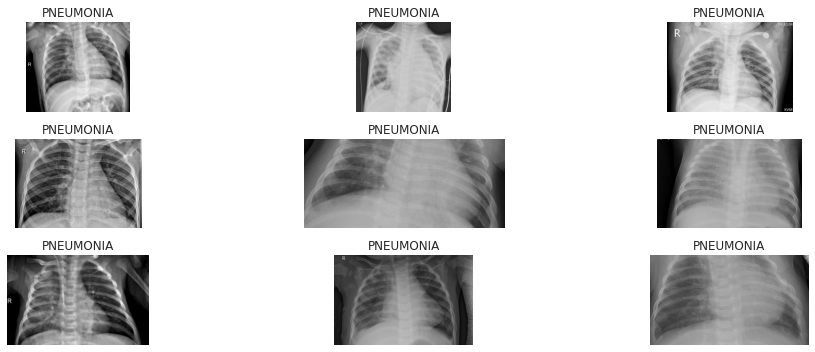

In [5]:
plt.figure(figsize=(15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("PNEUMONIA")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    

plt.tight_layout()

# NORMAL X-ray images

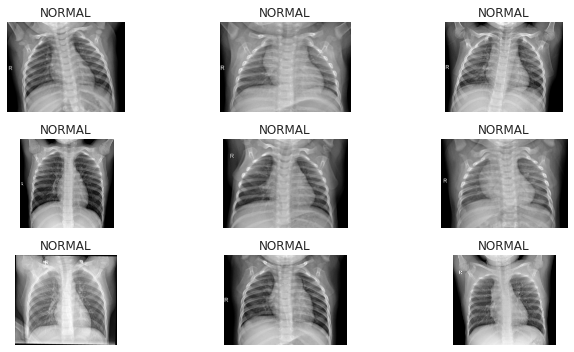

In [17]:
normal = os.listdir("/content/drive/My Drive/chest_xray1/train/NORMAL")
normal_dir = "/content/drive/My Drive/chest_xray1/train/NORMAL"

plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.title("NORMAL")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()


In [18]:
import glob

pneumonia_train = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_train = glob.glob(train_dir+"/NORMAL/*.jpeg")

- Creating dataframe for counting classes.

In [19]:
data = pd.DataFrame(np.concatenate([[0]*len(normal_train) , [1]*len(pneumonia_train)]),columns=["class"])

Labels are: `0 - NORMAL || 1 - PNEUMONIA`

In [20]:
data.head()

,class
0,0
1,0
2,0
3,0
4,0


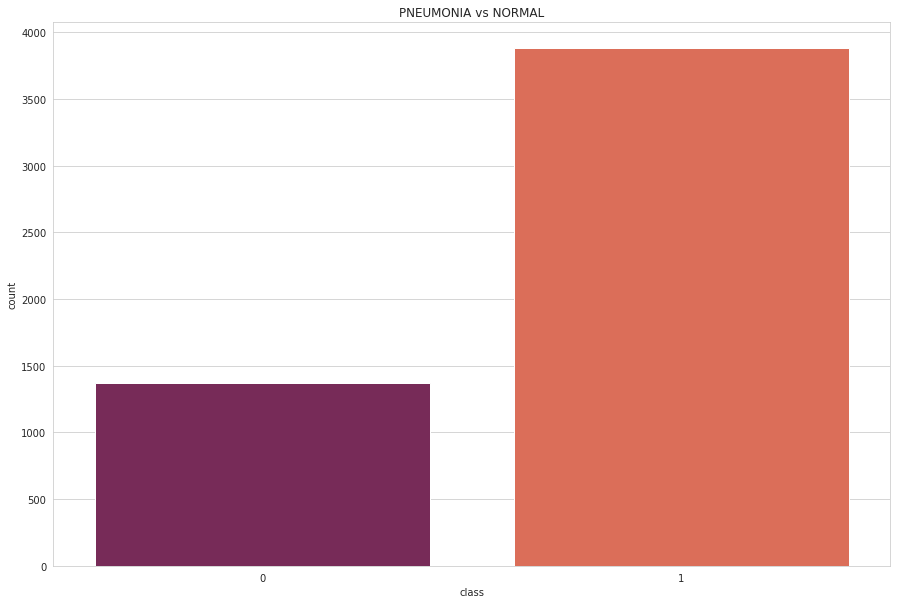

In [21]:
plt.figure(figsize=(15,10))
sns.countplot(data['class'],data=data,palette='rocket')
plt.title('PNEUMONIA vs NORMAL')
plt.show()

### There are more images of PNEUMONIA affected Xrays than NORMAL.

## Data Augmentation
- Using `ImageDataGenerator`, to augment our images so as to create a larger dataset for our model to train on..

In [22]:
img_Datagen = ImageDataGenerator(
      #  rescale = 1/255,
        #shear_range=10,
       # zoom_range=0.3,
      #  horizontal_flip=True,
       # vertical_flip=True,
        #brightness_range=[0.5,2.0],
        #width_shift_range = 0.2,
       # rotation_range=20,
        #fill_mode = 'nearest'

    rescale =1/255,
    #shear_range=10,
    zoom_range = 0.2,
    #horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
#     rotation_range=20,
    fill_mode = 'nearest',
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [43]:

train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=32,
                                       class_mode='binary',
                                       target_size=(224,224))
                                      

validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=32,
                                              class_mode='binary',
                                              target_size=(224,224))
                                            

test = val_Datagen.flow_from_directory(test_dir,
                                       batch_size=32,
                                       class_mode='binary',
                                        target_size=(224,224))
                                      

Found 5252 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [44]:
img, label = next(train)

# MobileNetV2

In [45]:
mobilenet_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in mobilenet_model.layers:
    layer.trainable=False
    
x = mobilenet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model3 = tf.keras.Model(inputs=mobilenet_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
model3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [46]:
history = model3.fit(train,epochs=20, 
                    validation_data=validation,
                     steps_per_epoch=164,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/20
164/164 [==============================] - 151s 897ms/step - loss: 0.1971 - accuracy: 0.9180 - val_loss: 0.3129 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 2/20
164/164 [==============================] - 109s 668ms/step - loss: 0.1614 - accuracy: 0.9330 - val_loss: 0.5477 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/20
164/164 [==============================] - 110s 669ms/step - loss: 0.1351 - accuracy: 0.9462 - val_loss: 0.2248 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 4/20
164/164 [==============================] - 110s 673ms/step - loss: 0.1099 - accuracy: 0.9559 - val_loss: 0.1957 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 5/20
164/164 [==============================] - 110s 674ms/step - loss: 0.1197 - accuracy: 0.9540 - val_loss: 0.5149 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 6/20
164/164 [==============================] - 109s 662ms/step - loss: 0.1107 - accuracy: 0.9554 - val_loss: 0.1257 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/20
164/164 [==========================

In [47]:
# Evaluating the model on train and test
score = model3.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model3.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

165/165 [==============================] - 109s 657ms/step - loss: 0.1059 - accuracy: 0.9551
Train Loss:  0.10587118566036224
Train Accuracy:  0.9550647139549255
20/20 [==============================] - 7s 334ms/step - loss: 0.2341 - accuracy: 0.9103

Test loss:  0.23413822054862976
Test Accuracy:  0.9102563858032227


Text(0.5, 1.0, 'Accuracy Evolution')

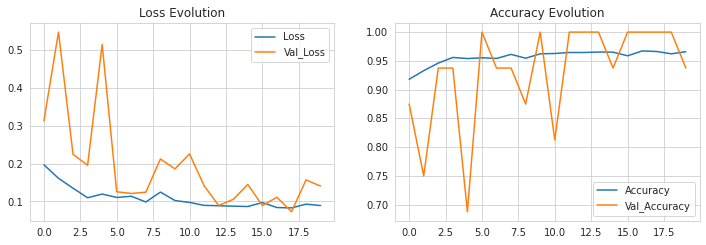

In [48]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [49]:
model3.save('mobilenetv2.h5')

# Fine Tuning
- One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

In [50]:

mobilenet_model.trainable = True

# Evaluating the Fine Tune model

In [51]:
# Fine tuning the mobilenetv2

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mobilenet_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobilenet_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [52]:
# Compiling the model
model3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [53]:
len(model3.trainable_variables)

58

In [54]:
fine_tune_epochs = 10
epochs_on_raw_model = 20

total_epochs =  epochs_on_raw_model + fine_tune_epochs

history_fine =model3.fit(train,epochs=total_epochs, 
                    validation_data=validation,
                    steps_per_epoch=164,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/30
164/164 [==============================] - 115s 681ms/step - loss: 0.1817 - accuracy: 0.9347 - val_loss: 27.3144 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
164/164 [==============================] - 110s 671ms/step - loss: 0.1130 - accuracy: 0.9579 - val_loss: 5.3111 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
164/164 [==============================] - 110s 672ms/step - loss: 0.1160 - accuracy: 0.9573 - val_loss: 5.6988 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/30
164/164 [==============================] - 110s 670ms/step - loss: 0.0765 - accuracy: 0.9732 - val_loss: 1.4269 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 5/30
164/164 [==============================] - 109s 662ms/step - loss: 0.0638 - accuracy: 0.9778 - val_loss: 0.4610 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 6/30
164/164 [==============================] - 110s 672ms/step - loss: 0.0595 - accuracy: 0.9795 - val_loss: 0.5483 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 7/30
164/164 [=========================

In [55]:
# Evaluating the model on train and test
score = model3.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model3.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

165/165 [==============================] - 110s 664ms/step - loss: 0.0326 - accuracy: 0.9869
Train Loss:  0.03259618207812309
Train Accuracy:  0.9868621230125427
20/20 [==============================] - 7s 327ms/step - loss: 0.3392 - accuracy: 0.9231

Test loss:  0.339248389005661
Test Accuracy:  0.9230769276618958


Text(0.5, 1.0, 'Accuracy Evolution')

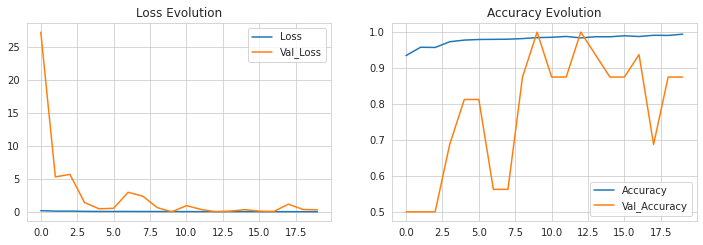

In [56]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_fine.history['loss'], label='Loss')
plt.plot(history_fine.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [57]:
# Saving the fine tuned model
model3.save('tuned_mobilenet.h5')